Insbesondere 12 Kombinationen zu testen.
10/12 abgeschlossen


,T,group_reg,hidden_dim,lam,lr,noise_std,pe_dim,mean_f1,std_f1
1,10,0.00,32,10.0,0.001,0.3,15,0.397223,0.007933
4,10,0.10,32,1.0,0.001,0.3,15,0.397203,0.009552
5,10,0.10,32,10.0,0.001,0.3,15,0.396739,0.007589
2,10,0.01,32,1.0,0.001,0.3,15,0.396380,0.010808
0,10,0.00,32,1.0,0.001,0.3,15,0.395610,0.011502
3,10,0.01,32,10.0,0.001,0.3,15,0.394814,0.006281
10,50,0.10,32,1.0,0.001,0.3,15,0.388429,0.013867
6,50,0.00,32,1.0,0.001,0.3,15,0.387601,0.013260
8,50,0.01,32,1.0,0.001,0.3,15,0.387594,0.013593
7,50,0.00,32,10.0,0.001,0.3,15,0.385865,0.010931


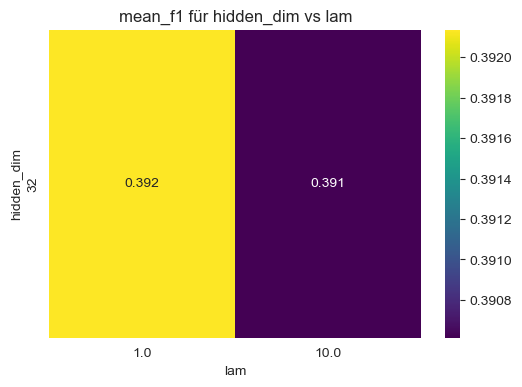

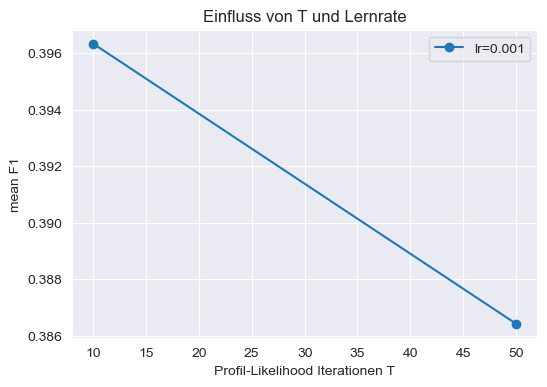

In [7]:
## NIMO Hyperparameter-Tuning

# Cell 1: Imports und Setup
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.metrics import f1_score
from methods.nimo import NIMO  # NIMO-Klasse
from methods.nimo import run_nimo  # falls du die komplette run_nimo-Funktion nutzen möchtest
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Daten laden
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test  = np.load("../data/splits/X_test.npy")
y_test  = np.load("../data/splits/y_test.npy")


# Cell 3: Parameter-Grid definieren
param_grid = {
    'hidden_dim':   [32], #, 64, 128
    'pe_dim':       [X_train.shape[1]],  # fest
    'lam':          [1.0, 10.0], # 0.1,
    'noise_std':    [0.3], #0.0, 0.1,
    'group_reg':    [0.0, 0.01, 0.1],
    'lr':           [1e-3], #, 1e-2
    'T':            [10, 50]
}
grid = list(ParameterGrid(param_grid))
print(f"Insbesondere {len(grid)} Kombinationen zu testen.")


# Cell 4: Cross-Validation-Funktion
def evaluate_config(cfg, X, y, n_splits=3, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1_scores = []
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        # run_nimo nutzt cfg und gibt best_f1 auf Test zurück, wir adaptieren kurz:
        out = run_nimo(
            X_tr, y_tr, X_val, y_val,
            rng=None,
            iteration=0,
            randomState=random_state,
            X_columns=None,
            **cfg  # setzt hidden_dim, lam, noise_std, group_reg, lr, T
        )
        f1_scores.append(out['best_f1'])
    return np.mean(f1_scores), np.std(f1_scores)


# Cell 5: Alle Konfigurationen evaluieren (evtl. lange Laufzeit!)
results = []
for i, cfg in enumerate(grid):
    mean_f1, std_f1 = evaluate_config(cfg, X_train, y_train)
    results.append({**cfg, 'mean_f1': mean_f1, 'std_f1': std_f1})
    if (i+1) % 10 == 0:
        print(f"{i+1}/{len(grid)} abgeschlossen")
results_df = pd.DataFrame(results)


# Cell 6: Top-10 Ergebnisse anzeigen
top10 = results_df.sort_values('mean_f1', ascending=False).head(10)
display(top10)


# Cell 7: Heatmap von zwei Parametern (z.B. lam vs. hidden_dim)
import seaborn as sns
pivot = results_df.pivot_table(
    index='hidden_dim', columns='lam', values='mean_f1', aggfunc='mean'
)
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("mean_f1 für hidden_dim vs lam")
plt.show()


# Cell 8: Einfluss von T und lr visualisieren
plt.figure(figsize=(6,4))
for lr_val in sorted(results_df['lr'].unique()):
    sub = results_df[results_df['lr']==lr_val].groupby('T')['mean_f1'].mean()
    plt.plot(sub.index, sub.values, marker='o', label=f"lr={lr_val}")
plt.xlabel("Profil-Likelihood Iterationen T")
plt.ylabel("mean F1")
plt.legend()
plt.title("Einfluss von T und Lernrate")
plt.grid(True)
plt.show()


